## Script for a creation of 3d initial model for reconstruction of amyloid-like fibrils

The script was developed by Robert Bücker and refactored (for clarity) by Aleksandr Golubev (DESY, CSSB, Landau Lab).

References:
1) Bücker, R., Seuring, C., Cazey, C. et al. The Cryo-EM structures of two amphibian antimicrobial cross-β amyloid fibrils. Nat Commun 13, 4356 (2022). 
2) Scheres, S. H. W. Amyloid structure determination in RELION-3.1. Acta Crystallogr D Struct Biol 76, 94–101 (2020).

The useful way to handle the notebook is to copy it with different names for each polymorph type into the main relion project folder and run from it.

Requirements: pyem, mrcfile, numpy, pandas, matplotlib

In [ ]:
from pyem import star
import mrcfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Settings

In [ ]:
out_folder = 'IniModel/created_in_jupiter/' # Don't forget to change name of output folder for each polymorph
%mkdir -p {out_folder}

large_it = 5 # number of iterations for modelling from big classes

co = 372.5 # crossover distance in Angstroms. It could be easily measured in Fiji based on big 2d classes (to cathc all crossover) or micrographs

pxs_big = 6.10133 # Pixel size for initial modelling from big classes
pxs_small = 0.832 # Pixel size for initial modelling from small classes

# Settings for big classes modeling
big_classes = 'Class2D/job001/run_it020_classes.mrcs' # pathway to the big classes
classes = [1,2] # position of the class you want to build model with in the input .mrc. In this case we take two classes: first and second.
rotation = [0,0] # rotate firbil clockwise\contrclockwise. Start from 0 and then adjust accordingly - from 2 to -2, is a good range
shift = [0,0] # y-axial movement. Start from 0 and then adjust accordingly - from 1 to -1, is a good range

# Settings for small classes modeling
small_classes = 'Select/job077/class_averages.star' # pathway to the small classes

## Adjustment graph for big classes modeling
Just run the cell below

   0/   0 sec ............................................................~~(,_,">
 Reading map: IniModel/ht1.3//big_class_5.mrc
 Done reading map!
         The value in the input image header (= 6.10133) is used instead.
 Done writing IniModel/ht1.3//big_class_5.mrc
   0/   0 sec ............................................................~~(,_,">
   0/   0 sec ............................................................~~(,_,">
 Reading map: IniModel/ht1.3//big_class_6.mrc
 Done reading map!
         The value in the input image header (= 6.10133) is used instead.
 Done writing IniModel/ht1.3//big_class_6.mrc
   0/   0 sec ............................................................~~(,_,">


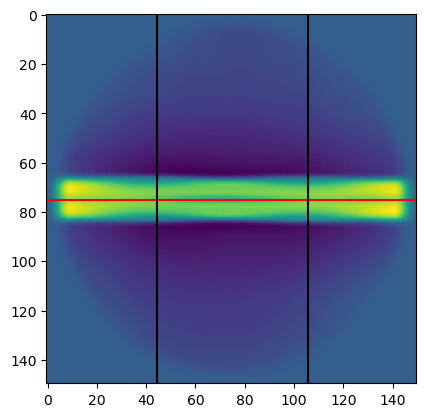

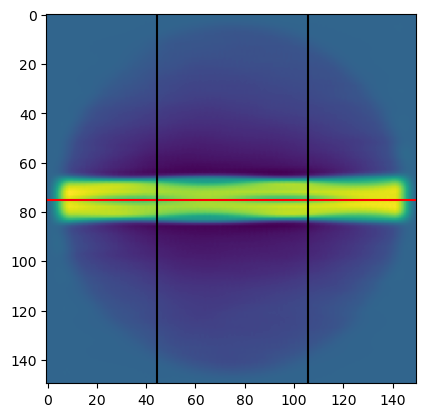

In [ ]:
# %matplotlib widget+-

fns = []
for cl, rot, sh in zip (classes, rotation, shift):
    !relion_image_handler --i {cl}@{big_classes} --o {out_folder}/big_class_{cl}.mrc
    !relion_project --i {out_folder}/big_class_{cl}.mrc --o {out_folder}/big_class_{cl}.mrc --psi {rot}
    !relion_image_handler --i {out_folder}/big_class_{cl}.mrc --o {out_folder}/big_class_{cl}.mrc --shift_y {sh}
    fns.append(f'{out_folder}/big_class_{cl}.mrc')

    with mrcfile.open(f'{out_folder}/big_class_{cl}.mrc') as fh:
        ref_img = fh.data
    fh, ax = plt.subplots(1,1)    
    ax.imshow(ref_img)
    ax.axhline(ref_img.shape[0]/2,color='r')
    ax.axvline(ref_img.shape[1]//2 - co/pxs_big/2, color='k')
    ax.axvline(ref_img.shape[1]//2 + co/pxs_big/2, color='k')
    
star.write_star(f'{out_folder}/big_class.star', pd.DataFrame({'rlnReferenceImage': fns}), optics=False)

If the position of classes is fine (by eye) > just run the next cell

 Setting maximum resolution to 12.2027
 *   mydiv= 117.22 myangpix= 6.35555 myfit= 0.779648
 *   mydiv= 118.848 myangpix= 6.26849 myfit= 0.848412
 *   mydiv= 120.476 myangpix= 6.18378 myfit= 0.476471
 *   mydiv= 122.105 myangpix= 6.10133 myfit= 0.10453
 *** best_angpix= 6.10133 rectangles xsize= 122.105
 maxres= 12.2027 angpix= 6.10133 down_size= 150
 xrect= 122 yrect= 150 down_angpix= 6.10133
 max_shift= 1 mask_radius_pix= 73
 Reading in all images ...
   0/   0 sec ............................................................~~(,_,">
 Initialising reference(s) ...
   0/   0 sec ............................................................~~(,_,">
 Iteration 1 of 5
   0/   0 sec ............................................................~~(,_,">
 Iteration 2 of 5
   1/   1 sec ............................................................~~(,_,">
 Iteration 3 of 5
   0/   0 sec ............................................................~~(,_,">
 Iteration 4 of 5
   0/   0 sec ..........

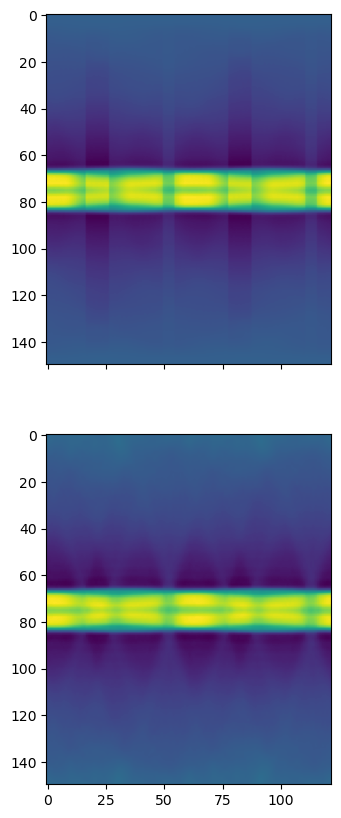

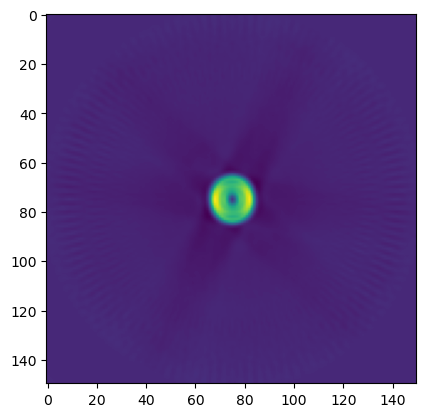

In [ ]:
!relion_helix_inimodel2d --i {out_folder}/big_class.star --iter {large_it} \
! --crossover_distance {co} --angpix {pxs_big} --o {out_folder}/big_class --j 40 \
! --mask_diameter -1 --search_shift 4 --search_angle 0.5

with mrcfile.open(f'{out_folder}/big_class_it{large_it:03d}_summed_classes.mrcs') as fh:
    summed_classes = fh.data
with mrcfile.open(f'{out_folder}/big_class_it{large_it:03d}_reprojections.mrcs') as fh:
    reprojections = fh.data
with mrcfile.open(f'{out_folder}/big_class_it{large_it:03d}_reconstructed.mrcs') as fh:
    reconstructed = fh.data
    
fh, ax = plt.subplots(2,1,sharex=True,sharey=True,figsize=(10,10))
print(180/co*4.85)

ax[0].imshow(summed_classes)
ax[1].imshow(reprojections)

fh, ax = plt.subplots(1,1)
ax.imshow(reconstructed)

If the model look 'bad' - try to tune crossover or add\use different classes.
If the model looks 'good' - continuous and make sense - you you can find it written in IniModel/your_folder_name/big_class_class001_rec3d.mrc.
To rescale map for processing check command below

## Small classes modelling
Give better results if one have good set of 2d classes that cover all crossover region, which is not easy to get. Most of the time - modelling from big classes is enough.

In [ ]:
# Use the command to scale the map for refinement/3D classification or to make a reference for small classes modelling, if you want it.
!relion_image_handler --i {out_folder}/big_class_class001_rec3d.mrc --o {out_folder}/big_class_class001_rec3d_rescaled.mrc \
--new_box 300 --rescale_angpix {pxs_small} --angpix {pxs_big}

1.33/1.33 min ............................................................~~(,_,">


In [ ]:
# uncomment the line with '--iniref..' to work with reference created above. Cnahge symmetry if needed - it helps
!relion_helix_inimodel2d --i {small_classes} --iter 10 --crossover_distance {co} --angpix {pxs_small} --o {out_folder}/small_class --mask_diameter 150 \
--search_shift 20 --search_angle 1 --step_angle 1 --maxres 4.5 --j 40 \
#--iniref {out_folder}/big_class_class001_rec3d_rescaled.mrc \
--sym 1

 *   mydiv= 316.667 myangpix= 2.4 myfit= 0.666656
 *   mydiv= 322.756 myangpix= 2.35472 myfit= 0.756409
 *   mydiv= 328.846 myangpix= 2.31111 myfit= 0.84613
 *   mydiv= 334.936 myangpix= 2.26909 myfit= 0.935913
 *   mydiv= 341.026 myangpix= 2.22857 myfit= 0.974365
 *   mydiv= 347.115 myangpix= 2.18947 myfit= 0.884613
 *** best_angpix= 2.4 rectangles xsize= 316.667
 maxres= 4.5 angpix= 0.832 down_size= 104
 xrect= 317 yrect= 104 down_angpix= 2.4
 max_shift= 9 mask_radius_pix= 32
 Reading in all images ...
   1/   1 sec ............................................................~~(,_,">
 Initialising reference(s) ...
   0/   0 sec ............................................................~~(,_,">
 Iteration 1 of 10
   2/   2 sec ............................................................~~(,_,">
 Iteration 2 of 10
   2/   2 sec ............................................................~~(,_,">
 Iteration 3 of 10
   2/   2 sec ........................................................

just run

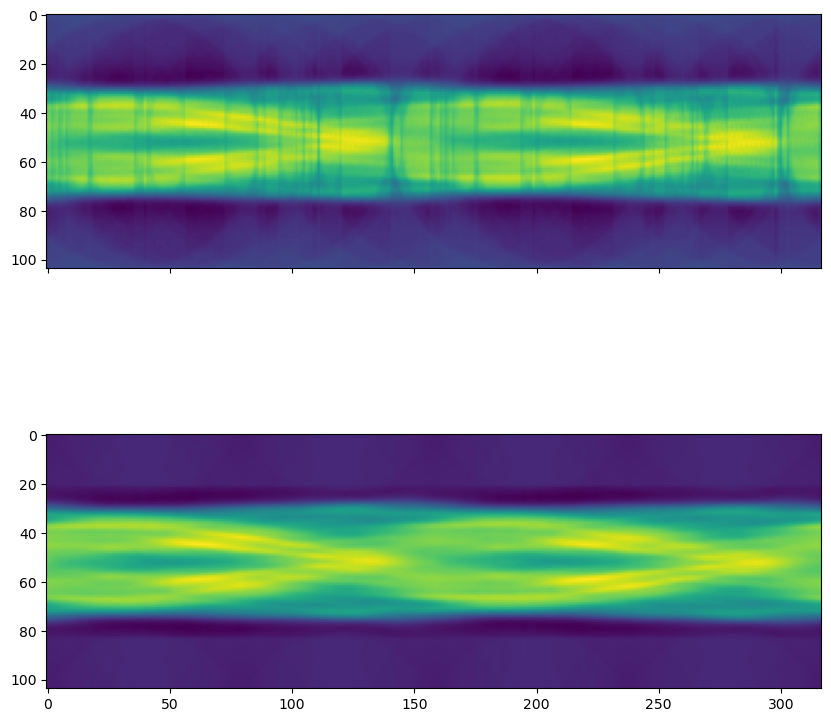

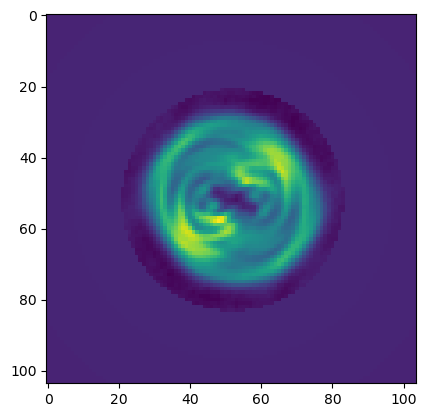

In [ ]:
with mrcfile.open(f'{out_folder}/small_class_it010_summed_classes.mrcs') as fh:
    summed_classes = fh.data
with mrcfile.open(f'{out_folder}/small_class_it010_reprojections.mrcs') as fh:
    reprojections = fh.data
with mrcfile.open(f'{out_folder}/small_class_it010_reconstructed.mrcs') as fh:
    reconstructed = fh.data
    
fh, ax = plt.subplots(2,1,sharex=True,sharey=True,figsize=(10,10))
ax[0].imshow(summed_classes)
ax[1].imshow(reprojections)
fh, ax = plt.subplots(1,1)
ax.imshow(reconstructed)